In [172]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from bs4 import BeautifulSoup
import json
import requests

import folium

import haversine as hs 

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import scipy.stats as stats

import pylab

%matplotlib inline

## King County Houses

In [173]:
# reading the csv file
df = pd.read_csv('data/kc_house_data.csv')
# previewing the DataFrame
df.head() 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,nan,0.00,...,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,...,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,...,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,...,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,...,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [174]:
# generating descriptive statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,19221.00,21534.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,0.01,0.23,3.41,7.66,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,0.00,0.00,4.00,8.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Narrowing down our price range

In [176]:
std = df.price.std()
print('std: ',std)
mean = df.price.mean()
print('mean: ', mean)
std_1 = mean + std
std_1m = mean - std
print('mean +1 std: ',std_1)
print('mean -1 std: ',std_1m)

std:  367368.1401013945
mean:  540296.5735055795
mean +1 std:  907664.713606974
mean -1 std:  172928.433404185


In [177]:
df = df.loc[(df['price']<std_1) & (df['price']>std_1m)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19205 entries, 0 to 21596
Data columns (total 21 columns):
id               19205 non-null int64
date             19205 non-null object
price            19205 non-null float64
bedrooms         19205 non-null int64
bathrooms        19205 non-null float64
sqft_living      19205 non-null int64
sqft_lot         19205 non-null int64
floors           19205 non-null float64
waterfront       17082 non-null float64
view             19149 non-null float64
condition        19205 non-null int64
grade            19205 non-null int64
sqft_above       19205 non-null int64
sqft_basement    19205 non-null object
yr_built         19205 non-null int64
yr_renovated     15798 non-null float64
zipcode          19205 non-null int64
lat              19205 non-null float64
long             19205 non-null float64
sqft_living15    19205 non-null int64
sqft_lot15       19205 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.2+ MB


In [178]:
#dropping unnecessary columns
drop = ['id','date', 'yr_built', 'bedrooms', 'bathrooms','sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15']
df = df.drop(columns = drop, axis=1)

In [179]:
df.columns

Index(['price', 'sqft_living', 'grade', 'lat', 'long'], dtype='object')

In [180]:
df.isnull().sum()

price          0
sqft_living    0
grade          0
lat            0
long           0
dtype: int64

## King County Parks

In [181]:
# importing park data
# for entire data scraping process, please see other notebook

# reading the csv file
king_parks = pd.read_csv('data/ParkAddresses_wLatLong.csv', index_col='ID')
# previewing the DataFrame
king_parks.head()

,Address,Combined,Lat,Long
ID,,,,
0.00,Auburn Black Diamond Rd and SE Green Valley Rd...,"47.301182311345315, -122.17491469179195",47.30,-122.17
1.00,NE 165th St and 179th Pl NE Redmond WA 98072,"47.74702351303733, -122.09810603412113",47.75,-122.10
2.00,NaN,NaN,nan,nan
3.00,NE 138th and Juanita Drive NE Kirkland WA 98028,"47.72417796430824, -122.2384511052857",47.72,-122.24
4.00,S 284th Pl and 37th Ave S Federal Way WA 98003,"47.34814028865613, -122.2811067550002",47.35,-122.28


In [182]:
#create function to find distances between all points in DF and return matrix
def find_distance(dataframe):
    dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
    
    #convert lat and long to radians
    dataframe[['lat_radians','long_radians']] = (np.radians(dataframe.loc[:,['Lat','Long']]))
    
    #create list matrix (results in km)          
    dist_matrix = (dist.pairwise
    (df[['lat_radians_A','long_radians_A']],
     dataframe[['lat_radians','long_radians']])*6371)
                                                 
    #return a matrix DataFrame
    return pd.DataFrame(dist_matrix)  

In [183]:
#convert lat and long to radians in housing data
df[['lat_radians_A','long_radians_A']] = (np.radians(df.loc[:,['lat','long']]))

In [184]:
park_matrix = find_distance(king_parks)

In [185]:
#find min distance in each row
park_min_matrix = park_matrix.where(park_matrix.values == park_matrix.min(
    axis=1)[:,None]).drop_duplicates()

In [186]:
#create a new column with only min distance and remove the rest 
park_min_matrix['min_dist_park'] = park_min_matrix[park_min_matrix.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)
nearest_park = park_min_matrix['min_dist_park']

In [187]:
df = df.join(nearest_park)

In [188]:
df.head()

,price,sqft_living,grade,lat,long,lat_radians_A,long_radians_A,min_dist_park
0,221900.00,1180,7,47.51,-122.26,0.83,-2.13,2.038307293948517
1,538000.00,2570,7,47.72,-122.32,0.83,-2.13,5.052057710119824
2,180000.00,770,6,47.74,-122.23,0.83,-2.13,1.337990461344532
3,604000.00,1960,7,47.52,-122.39,0.83,-2.14,2.448557143643891
4,510000.00,1680,8,47.62,-122.05,0.83,-2.13,2.6728316989804743


In [189]:
df['min_dist_park']= df['min_dist_park'].astype('float64')

## King County Top Schools

In [190]:
# importing school data
# for entire data obtaining process, please see other notebook

# reading the csv file
top_schools_df = pd.read_csv('data/top_schools.csv')
# previewing the DataFrame
top_schools_df.head()

,Unnamed: 0,year,ncessch,school_name,state_name,lea_name,zip_location,latitude,longitude,county_code,school_level,school_type
0,43,2015,530039000058,Ardmore Elementary School,Washington,Bellevue School District,98008,47.64,-122.12,53033.00,Primary,Regular school
1,44,2015,530039000060,Bellevue High School,Washington,Bellevue School District,98004,47.60,-122.20,53033.00,High,Regular school
2,45,2015,530039000062,Bennett Elementary School,Washington,Bellevue School District,98008,47.62,-122.10,53033.00,Primary,Regular school
3,46,2015,530039000063,Cherry Crest Elementary School,Washington,Bellevue School District,98005,47.64,-122.17,53033.00,Primary,Regular school
4,47,2015,530039000064,Chinook Middle School,Washington,Bellevue School District,98004,47.63,-122.21,53033.00,Middle,Regular school


In [191]:
top_schools_df.drop(columns = 'Unnamed: 0', axis=1, inplace=True)

In [192]:
top_schools_df.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,latitude,longitude,county_code,school_level,school_type
0,2015,530039000058,Ardmore Elementary School,Washington,Bellevue School District,98008,47.64,-122.12,53033.00,Primary,Regular school
1,2015,530039000060,Bellevue High School,Washington,Bellevue School District,98004,47.60,-122.20,53033.00,High,Regular school
2,2015,530039000062,Bennett Elementary School,Washington,Bellevue School District,98008,47.62,-122.10,53033.00,Primary,Regular school
3,2015,530039000063,Cherry Crest Elementary School,Washington,Bellevue School District,98005,47.64,-122.17,53033.00,Primary,Regular school
4,2015,530039000064,Chinook Middle School,Washington,Bellevue School District,98004,47.63,-122.21,53033.00,Middle,Regular school


In [193]:
#geographic distance calculator
#function that identifies the distance between a point of interest and house 
def distance_to(point_of_interest):
    distance = df[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [194]:
top_school_coordinates = []
x = round(top_schools_df.latitude, 2)
y = round(top_schools_df.longitude, 2)
top_school_coordinates = list(zip(x,y))

In [195]:
for i in range(len(top_school_coordinates)):
    df[f'top_school_{i}'] = distance_to(top_school_coordinates[i])

top_school_cols = []
for i in range(len(top_school_coordinates)):
    top_school_cols.append(f'top_school_{i}')
    df['closest_distance_to_top_school'] = df[top_school_cols].min(axis=1)

In [196]:
df.drop(columns = top_school_cols, axis=1, inplace=True)
rad_cols = ['lat_radians_A', 'long_radians_A']
df.drop(columns=rad_cols, axis=1, inplace=True)
df.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school
0,221900.00,1180,7,47.51,-122.26,2.04,0.26
1,538000.00,2570,7,47.72,-122.32,5.05,0.68
2,180000.00,770,6,47.74,-122.23,1.34,2.00
3,604000.00,1960,7,47.52,-122.39,2.45,1.73
4,510000.00,1680,8,47.62,-122.05,2.67,1.18


## King County Top 10 Coffee Shops

In [197]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

keys = get_keys("/Users/dtunnicliffe/.secret/yelp_api.json")
api_key = keys['api_key']

term = 'coffee'
location = 'King County, WA'
SEARCH_LIMIT = 10
espresso = pd.DataFrame([])
def yelp(term, location, SEARCH_LIMIT):
    global espresso
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {
    'Authorization': f'Bearer {api_key}',
    }
    url_params = {
    'term': term.replace(' ', '+'),
    'location': location.replace(' ', '+'),
    'limit': SEARCH_LIMIT,
    'sort_by': 'rating'
    }
    response = requests.get(url, headers=headers, params=url_params)
    df_temp = pd.DataFrame.from_dict(response.json()['businesses'])
    espresso = espresso.append(df_temp)
    return espresso

In [198]:
espresso = yelp(term, location, SEARCH_LIMIT)

In [199]:
espresso.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,S6CXIQ5KrMpTPZf1eNMa2w,five-stones-coffee-company-redmond,Five Stones Coffee Company,https://s3-media3.fl.yelpcdn.com/bphoto/OmzSO6...,False,https://www.yelp.com/biz/five-stones-coffee-co...,414,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}]",4.50,"{'latitude': 47.67583, 'longitude': -122.12471}",[delivery],$$,"{'address1': '8102 161st Ave NE', 'address2': ...",+14252420099,(425) 242-0099,37007.96
1,EWqgeiGor-aVJlMLc8iSKw,boon-boona-coffee-renton,Boon Boona Coffee,https://s3-media3.fl.yelpcdn.com/bphoto/tVH2Gx...,False,https://www.yelp.com/biz/boon-boona-coffee-ren...,207,"[{'alias': 'coffeeroasteries', 'title': 'Coffe...",4.50,"{'latitude': 47.4797895, 'longitude': -122.206...","[delivery, pickup]",$,"{'address1': '724 S 3rd St', 'address2': 'Ste ...",+14254968618,(425) 496-8618,31528.44
2,v7xfqk9f7N8A98AQ2kddWg,anchorhead-coffee-bellevue-3,Anchorhead Coffee,https://s3-media3.fl.yelpcdn.com/bphoto/ErNP7S...,False,https://www.yelp.com/biz/anchorhead-coffee-bel...,70,"[{'alias': 'coffeeroasteries', 'title': 'Coffe...",4.50,"{'latitude': 47.61509, 'longitude': -122.194026}",[delivery],NaN,"{'address1': '555 110th Ave NE', 'address2': '...",,,36458.00
3,t2DOOFh-oJLddtpxbVlDrQ,huxdotter-coffee-north-bend,Huxdotter Coffee,https://s3-media3.fl.yelpcdn.com/bphoto/MdLMtc...,False,https://www.yelp.com/biz/huxdotter-coffee-nort...,83,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.50,"{'latitude': 47.493445, 'longitude': -121.787556}",[],$,"{'address1': '101 W Park St', 'address2': 'Ste...",,,7198.39
4,-MzbuOLr2kAoqlQY8w7ECA,pioneer-coffee-north-bend-north-bend,Pioneer Coffee - North Bend,https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3i...,False,https://www.yelp.com/biz/pioneer-coffee-north-...,76,"[{'alias': 'coffeeroasteries', 'title': 'Coffe...",4.50,"{'latitude': 47.4956976441376, 'longitude': -1...",[],$,"{'address1': '202 W North Bend Way', 'address2...",+14252920957,(425) 292-0957,7452.31


In [200]:
great_coffee_coordinates = []
x = [round(coordinate['latitude'], 2) for coordinate in espresso['coordinates']]
y = [round(coordinate['longitude'], 2) for coordinate in espresso['coordinates']]
great_coffee_coordinates = list(zip(x,y))

In [201]:
for i in range(len(great_coffee_coordinates)):
    df[f'great_coffee_{i}'] = distance_to(great_coffee_coordinates[i])

great_coffee_cols = []
for i in range(len(great_coffee_coordinates)):
    great_coffee_cols.append(f'great_coffee_{i}')
    df['closest_distance_to_great_coffee'] = df[great_coffee_cols].min(axis=1)

In [202]:
#dropping unnecessary columns
df = df.drop(columns = great_coffee_cols, axis=1)
df.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee
0,221900.00,1180,7,47.51,-122.26,2.04,0.26,4.95
1,538000.00,2570,7,47.72,-122.32,5.05,0.68,14.81
2,180000.00,770,6,47.74,-122.23,1.34,2.00,10.63
3,604000.00,1960,7,47.52,-122.39,2.45,1.73,14.48
4,510000.00,1680,8,47.62,-122.05,2.67,1.18,8.55


## King County Churches of Scientology

In [203]:
#locations pulled from scientology-seattle.org
church_of_scientology_mission = (47.818100, -122.315430)
church_of_scientology_washington = (47.622380, -122.361020)
church_of_scientology_life_improvement_center = (47.615060, -122.327580)

In [204]:
#function that identifies the distance between a point of interest and house 
def distance_to(point_of_interest):
    distance = df[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [205]:
#creating new columns of distances from houses to point of interest
df['distance_to_scientology_m'] = distance_to(church_of_scientology_mission)
df['distance_to_scientology_w'] = distance_to(church_of_scientology_washington)
df['distance_to_scientology_l'] = distance_to(church_of_scientology_life_improvement_center)
df['closest_distance_to_scientology'] = df[['distance_to_scientology_m',
                                                        'distance_to_scientology_w',
                                                        'distance_to_scientology_l']].min(axis=1)

In [206]:
sci_cols = ['distance_to_scientology_m', 'distance_to_scientology_w',
           'distance_to_scientology_l']
df.drop(columns = sci_cols, axis=1, inplace=True)

In [207]:
df.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology
0,221900.00,1180,7,47.51,-122.26,2.04,0.26,4.95,12.71
1,538000.00,2570,7,47.72,-122.32,5.05,0.68,14.81,10.80
2,180000.00,770,6,47.74,-122.23,1.34,2.00,10.63,10.84
3,604000.00,1960,7,47.52,-122.39,2.45,1.73,14.48,11.55
4,510000.00,1680,8,47.62,-122.05,2.67,1.18,8.55,21.18


## Log-Transforming Features

Skewness: 2.07081534646944
Kurtosis: 4.115792045291801


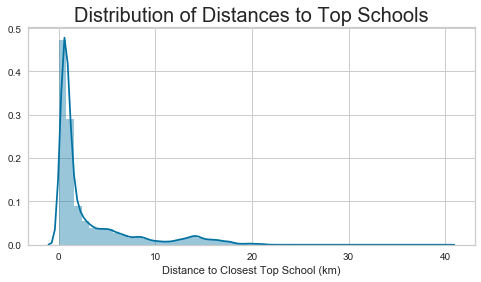

In [208]:
plt.figure(figsize=(8,4))
sns.distplot(df['closest_distance_to_top_school'])
plt.title("Distribution of Distances to Top Schools", fontsize=20)
plt.xlabel('Distance to Closest Top School (km)');
print("Skewness:", df['closest_distance_to_top_school'].skew())
print("Kurtosis:", df['closest_distance_to_top_school'].kurt())

In [209]:
# removing zeroes for log transformation
df.loc[df['closest_distance_to_top_school']==0.00, 'closest_distance_to_top_school']=0.01
#natural log transformation for 'closest_distance_to_top_school'.
df['log_school'] = df['closest_distance_to_top_school'].map(lambda x: np.log(x))

Skewness: 0.31498656015781384
Kurtosis: -0.4837932278849535


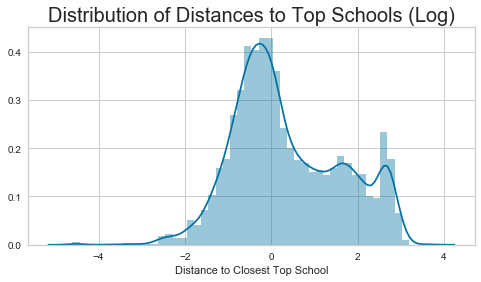

In [210]:
plt.figure(figsize=(8,4))
sns.distplot(df['log_school'])
plt.title("Distribution of Distances to Top Schools (Log)", fontsize=20)
plt.xlabel('Distance to Closest Top School');
print("Skewness:", df['log_school'].skew())
print("Kurtosis:", df['log_school'].kurt())

Skewness: 0.5617274905372351
Kurtosis: 0.7125009157364359


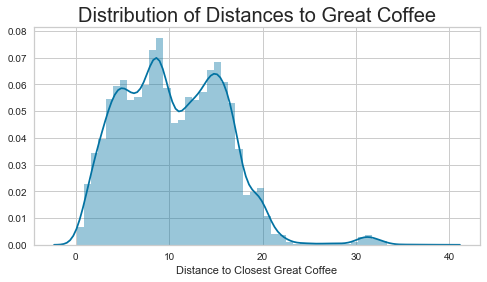

In [211]:
plt.figure(figsize=(8,4))
sns.distplot(df['closest_distance_to_great_coffee'])
plt.title("Distribution of Distances to Great Coffee", fontsize=20)
plt.xlabel('Distance to Closest Great Coffee');
print("Skewness:", df['closest_distance_to_great_coffee'].skew())
print("Kurtosis:", df['closest_distance_to_great_coffee'].kurt())

In [212]:
# removing zeroes for log transformation
df.loc[df['closest_distance_to_great_coffee']==0.00, 'closest_distance_to_top_school']=0.01
#natural log transformation for 'closest_distance_to_great_coffee'.
df['log_coffee'] = df['closest_distance_to_great_coffee'].map(lambda x: np.log(x))

Skewness: -1.1714703303238783
Kurtosis: 1.9350322960834787


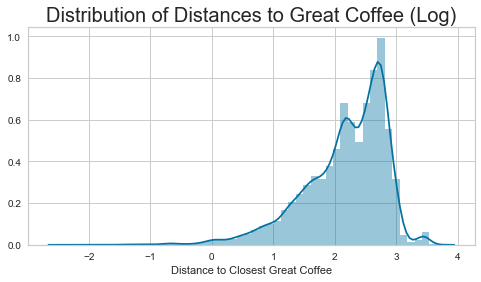

In [213]:
plt.figure(figsize=(8,4))
sns.distplot(df['log_coffee'])
plt.title("Distribution of Distances to Great Coffee (Log)", fontsize=20)
plt.xlabel('Distance to Closest Great Coffee');
print("Skewness:", df['log_coffee'].skew())
print("Kurtosis:", df['log_coffee'].kurt())

Skewness: 0.729624297126709
Kurtosis: -0.13070775209001573


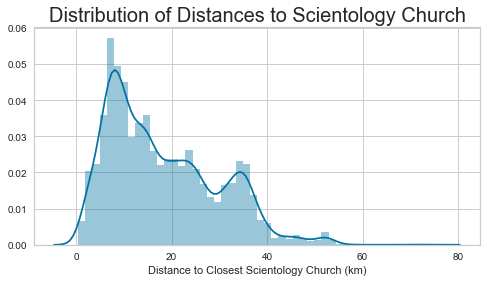

In [214]:
plt.figure(figsize=(8,4))
sns.distplot(df['closest_distance_to_scientology'])
plt.title("Distribution of Distances to Scientology Church", fontsize=20)
plt.xlabel('Distance to Closest Scientology Church (km)');
print("Skewness:", df['closest_distance_to_scientology'].skew())
print("Kurtosis:", df['closest_distance_to_scientology'].kurt())

In [215]:
# removing zeroes for log transformation
df.loc[df['closest_distance_to_scientology']==0.00, 'closest_distance_to_scientology']=0.01
#natural log transformation for 'closest_distance_to_scientology'.
df['log_scientology'] = df['closest_distance_to_scientology'].map(lambda x: np.log(x))

Skewness: -0.6186336629179573
Kurtosis: 0.16752897590293658


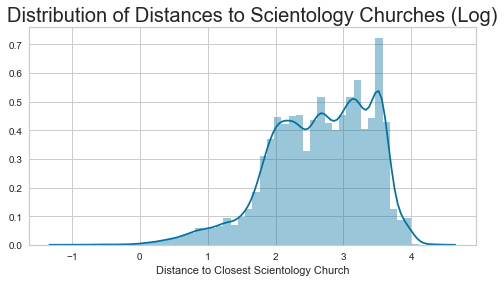

In [216]:
plt.figure(figsize=(8,4))
sns.distplot(df['log_scientology'])
plt.title("Distribution of Distances to Scientology Churches (Log)", fontsize=20)
plt.xlabel('Distance to Closest Scientology Church');
print("Skewness:", df['log_scientology'].skew())
print("Kurtosis:", df['log_scientology'].kurt())

Skewness: 1.205427367383708
Kurtosis: 3.9928978255283716


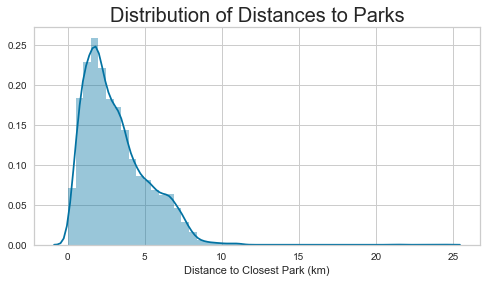

In [217]:
plt.figure(figsize=(8,4))
sns.distplot(df['min_dist_park'])
plt.title("Distribution of Distances to Parks", fontsize=20)
plt.xlabel('Distance to Closest Park (km)');
print("Skewness:", df['min_dist_park'].skew())
print("Kurtosis:", df['min_dist_park'].kurt())

In [218]:
# removing zeroes for log transformation
df.loc[df['min_dist_park']==0.00, 'min_dist_park']=0.01
#natural log transformation for 'min_dist_park'.
df['log_park'] = df['min_dist_park'].map(lambda x: np.log(x))

Skewness: -0.697074959578087
Kurtosis: 0.6535881306866189


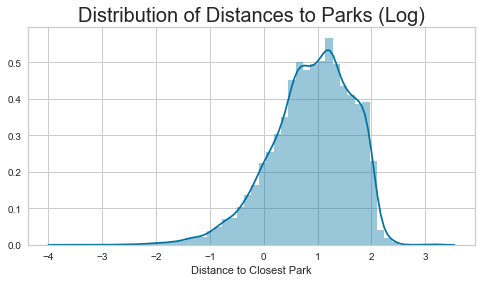

In [219]:
plt.figure(figsize=(8,4))
sns.distplot(df['log_park'])
plt.title("Distribution of Distances to Parks (Log)", fontsize=20)
plt.xlabel('Distance to Closest Park');
print("Skewness:", df['log_park'].skew())
print("Kurtosis:", df['log_park'].kurt())

In [220]:
df.isnull().sum()

price                                  0
sqft_living                            0
grade                                  0
lat                                    0
long                                   0
min_dist_park                       2712
closest_distance_to_top_school         0
closest_distance_to_great_coffee       0
closest_distance_to_scientology        0
log_school                             0
log_coffee                             0
log_scientology                        0
log_park                            2712
dtype: int64

In [221]:
df.dropna(inplace=True)
df.isnull().sum()

price                               0
sqft_living                         0
grade                               0
lat                                 0
long                                0
min_dist_park                       0
closest_distance_to_top_school      0
closest_distance_to_great_coffee    0
closest_distance_to_scientology     0
log_school                          0
log_coffee                          0
log_scientology                     0
log_park                            0
dtype: int64

In [222]:
# saving copy of DataFrame as csv file
df.to_csv('./data/all_features_with_logs.csv')

## Modeling

In [223]:
df.price.describe()

count    16493.00
mean    457743.09
std     178369.79
min     173000.00
25%     312000.00
50%     429900.00
75%     579000.00
max     907500.00
Name: price, dtype: float64

In [224]:
optimal = df.loc[(df['price'] > 180000) & (df['price']<700000)]
optimal.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,log_coffee,log_scientology,log_park
0,221900.00,1180,7,47.51,-122.26,2.04,0.26,4.95,12.71,-1.34,1.60,2.54,0.71
1,538000.00,2570,7,47.72,-122.32,5.05,0.68,14.81,10.80,-0.38,2.70,2.38,1.62
3,604000.00,1960,7,47.52,-122.39,2.45,1.73,14.48,11.55,0.55,2.67,2.45,0.90
4,510000.00,1680,8,47.62,-122.05,2.67,1.18,8.55,21.18,0.16,2.15,3.05,0.98
6,257500.00,1715,7,47.31,-122.33,5.40,15.84,16.58,33.95,2.76,2.81,3.53,1.69


In [225]:
features = ['sqft_living', 'log_school', 'log_park', 'log_scientology', 'log_coffee']
target = ['price']

In [226]:
optimal = optimal.drop(columns=['min_dist_park', 'closest_distance_to_top_school', 
             'closest_distance_to_great_coffee', 'closest_distance_to_scientology',
            'lat', 'long'], axis=1)

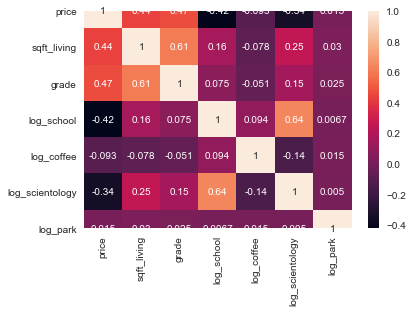

In [227]:
sns.heatmap(optimal.corr(), annot=True);

In [228]:
optimal.corr()

,price,sqft_living,grade,log_school,log_coffee,log_scientology,log_park
price,1.00,0.44,0.47,-0.42,-0.09,-0.34,0.01
sqft_living,0.44,1.00,0.61,0.16,-0.08,0.25,0.03
grade,0.47,0.61,1.00,0.08,-0.05,0.15,0.03
log_school,-0.42,0.16,0.08,1.00,0.09,0.64,0.01
log_coffee,-0.09,-0.08,-0.05,0.09,1.00,-0.14,0.02
log_scientology,-0.34,0.25,0.15,0.64,-0.14,1.00,0.01
log_park,0.01,0.03,0.03,0.01,0.02,0.01,1.00


In [229]:
from sklearn.linear_model import LinearRegression

# separate dataframe into feature matrix x and target vector y
X = optimal[features]
y = optimal[target]

# now we can instantiate our linear regression estimator and fit our data to it
lm1 = LinearRegression()
lm1.fit(X, y)

#print out intercept and coefficients for each variable
print(lm1.intercept_)
print(lm1.coef_)

#print R2 score
lm1_preds = lm1.predict(X)

print('R^2: ', r2_score(y, lm1_preds))

[384963.86508885]
[[   118.22464947 -34182.93183968    523.15530646 -53757.74177959
  -12057.07337277]]
R^2:  0.4875318574249097


In [230]:
features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee']
target = ['price']
X = optimal[features]
y = optimal[target]

# second iteration of model: removing parks
lm2 = LinearRegression().fit(X, y)

lm2_preds = lm2.predict(X)

print('R^2: ', r2_score(y, lm2_preds))

R^2:  0.4875233463395676


Although it seemed wise to remove parks, our R2 score actually dropped a bit as a result.

In [231]:
# trying without coffee but with parks 

features = ['sqft_living', 'log_school', 'log_scientology', 'log_park']
target = ['price']
X = optimal[features]
y = optimal[target]

lm3 = LinearRegression().fit(X, y)

lm3_preds = lm3.predict(X)

print('R^2: ', r2_score(y, lm3_preds))

R^2:  0.48429669865209435


R2 also drops when we remove coffee.

In [232]:
# trying with only sqft_living and school

features = ['sqft_living', 'log_school']
target = ['price']
X = optimal[features]
y = optimal[target]

lm4 = LinearRegression().fit(X, y)

lm4_preds = lm4.predict(X)

print('R^2: ', r2_score(y, lm4_preds))

R^2:  0.44450885097627924


In [233]:
# trying with all but scientology

features = ['sqft_living', 'log_school', 'log_park', 'log_coffee']
target = ['price']
X = optimal[features]
y = optimal[target]

# fifth iteration of model: no scientology
lm5 = LinearRegression().fit(X, y)

lm5_preds = lm5.predict(X)

print('R^2: ', r2_score(y, lm5_preds))

R^2:  0.4445401981951761


Drops further. It seems our best bet is to have all the available features.

In [234]:
features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee', 'log_park']
target = ['price']
X = optimal[features]
y = optimal[target]

# sixth iteration of model: with all and train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm6 = LinearRegression().fit(X_train, y_train)
lm6_preds = lm6.predict(X_test)

print('R^2: ', r2_score(y_test, lm6_preds))

R^2:  0.49785563228347385


This is the best one so far; the R2 improves when we use all features and train_test_split.

In [235]:
# creating an interaction column for school and scientology
# because there is multicolinearity
optimal['interaction'] = optimal['log_school'] * optimal['log_scientology']

features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee', 'log_park', 'interaction']
target = ['price']
X = optimal[features]
y = optimal[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm7 = LinearRegression().fit(X_train, y_train)
lm7_preds = lm7.predict(X_test)

print('R^2: ', r2_score(y_test, lm7_preds))

R^2:  0.49939821300963616


This is the best one so far. 

In [236]:
optimal.grade.unique()

array([ 7,  8,  9,  6,  5, 10,  4,  3, 11])

In [237]:
grade_dums = pd.get_dummies(optimal.grade, prefix='grade', drop_first=True)

In [238]:
grade_dums.head()

,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
6,0,0,0,1,0,0,0,0


In [239]:
optimal = optimal.drop(['grade'], axis=1)
optimal_with_grade = pd.concat([optimal, grade_dums], axis=1)
optimal_with_grade.head()

,price,sqft_living,log_school,log_coffee,log_scientology,log_park,interaction,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11
0,221900.00,1180,-1.34,1.60,2.54,0.71,-3.41,0,0,0,1,0,0,0,0
1,538000.00,2570,-0.38,2.70,2.38,1.62,-0.91,0,0,0,1,0,0,0,0
3,604000.00,1960,0.55,2.67,2.45,0.90,1.34,0,0,0,1,0,0,0,0
4,510000.00,1680,0.16,2.15,3.05,0.98,0.50,0,0,0,0,1,0,0,0
6,257500.00,1715,2.76,2.81,3.53,1.69,9.74,0,0,0,1,0,0,0,0


In [240]:
optimal_with_grade['interaction'] = optimal_with_grade['log_school'] * optimal_with_grade['log_scientology']
features = ['sqft_living', 'log_coffee', 'log_park', 'interaction', 'log_school', 'log_scientology', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']
target = ['price']
X = optimal_with_grade[features]
y = optimal_with_grade[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm8 = LinearRegression().fit(X_train, y_train)
lm8_preds = lm8.predict(X_test)

print('R^2: ', r2_score(y_test, lm8_preds))

R^2:  0.5602065784329902


This has once again improved with the addition of the grade column.

### Quantile Tranformation

Skewness: 0.7651743646573521
Kurtosis: 0.8677398638009155


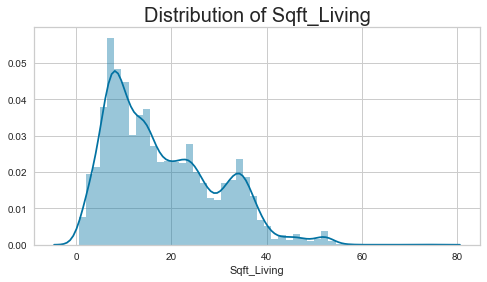

In [241]:
plt.figure(figsize=(8,4))
sns.distplot(df['Closest_Distance_to_Scientology'])
plt.title("Closest Distance to Scientology", fontsize=20)
plt.xlabel('Closest Distance to Scientology');
print("Skewness:", df['closest_distance_to_scientology'].skew())
print("Kurtosis:", df['closest_distance_to_scientology'].kurt())

In [242]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
to_transform= ['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'price']
df[to_transform] = qt.fit_transform(df[to_transform])

Skewness: 0.003628284074277272
Kurtosis: 0.04166152893410047


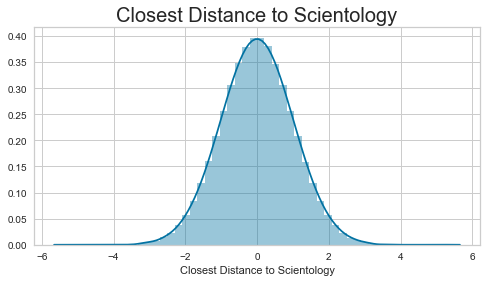

In [255]:
plt.figure(figsize=(8,4))
sns.distplot(df['closest_distance_to_scientology'])
plt.title("Closest Distance to Scientology", fontsize=20)
plt.xlabel('Closest Distance to Scientology');
print("Skewness:", df['closest_distance_to_scientology'].skew())
print("Kurtosis:", df['closest_distance_to_scientology'].kurt())

In [244]:
grade_dums = pd.get_dummies(df.grade, prefix='grade', drop_first=True)

In [245]:
df = df.drop(['grade'], axis=1)
df = pd.concat([df, grade_dums], axis=1)
df.head()

,price,sqft_living,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,log_coffee,...,log_park,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,-1.60,-1.08,47.51,-122.26,-0.31,-1.61,-0.93,-0.24,-1.34,1.60,...,0.71,0,0,0,1,0,0,0,0,0
1,0.49,0.94,47.72,-122.32,0.92,-0.50,0.71,-0.40,-0.38,2.70,...,1.62,0,0,0,1,0,0,0,0,0
2,-2.54,-2.14,47.74,-122.23,-0.84,0.36,0.09,-0.39,0.69,2.36,...,0.29,0,0,1,0,0,0,0,0,0
3,0.78,0.17,47.52,-122.39,-0.08,0.30,0.65,-0.33,0.55,2.67,...,0.90,0,0,0,1,0,0,0,0,0
4,0.37,-0.22,47.62,-122.05,0.02,0.08,-0.25,0.37,0.16,2.15,...,0.98,0,0,0,0,1,0,0,0,0


In [246]:
df['interaction'] = df['closest_distance_to_top_school'] * df['closest_distance_to_scientology']
features = ['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'interaction', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']
target = ['price']
X = df[features]
y = df[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm8 = LinearRegression().fit(X_train, y_train)
lm8_preds = lm8.predict(X_test)

print('R^2: ', r2_score(y_test, lm8_preds))

R^2:  0.6308144610145117


By quantile tranforming our data to achieve a more normal distribution, we are able to achieve a higher R2 score.

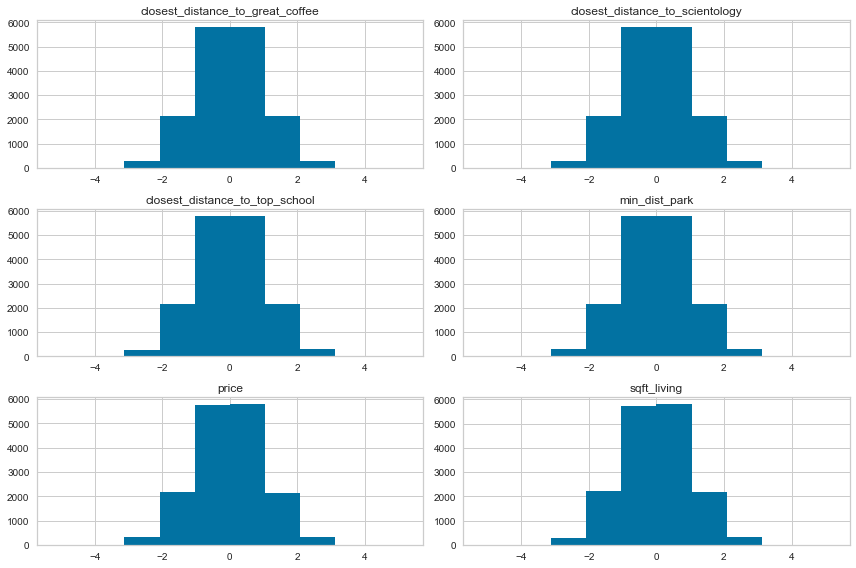

In [254]:
df[['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'price']].hist(figsize=(12, 8))
plt.tight_layout();